# Mobile price classification with multilayer perceptron
## PyTorch
Erik Matovič and Jakub Horvat

[Dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv)

### 0. Imports

In [199]:
import wandb
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from utils import split_train_val
from typing import Tuple, List

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(use_cuda, device)

True cuda:0


### 2. Data transformation
 - no null values
 - load train and test datasets & from test dataset make validation and test dataset

In [200]:
from sklearn.preprocessing import MinMaxScaler

def rescale(df: pd.DataFrame, col: str) -> MinMaxScaler:
    """
    Rescale values using scikit-learn's MinMaxScaler.
    :param: df - dataframe
    :returns: rescaled values
    """
    scaler = MinMaxScaler()

    # The scaler expects the data to be shaped as (x, y), 
    # so we add a dimension using reshape.
    values = df[col].values.reshape(-1, 1)
    values_scaled = scaler.fit_transform(values)
    df.loc[:, col] = values_scaled
    return scaler

In [201]:
# read datasets
df_train = pd.read_csv('../data/train.csv', sep=',')
df_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [202]:
# rescale datasets
scaler = rescale(df_train, 'price_range')
df_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,0.333333
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,0.666667
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,0.666667
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,0.666667
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0.000000
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,0.666667
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,1.000000
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0.000000


In [203]:
df_train = pd.DataFrame({'ram': df_train.ram, 'price_range': df_train.price_range})
df_train

,ram,price_range
0,2549,0.333333
1,2631,0.666667
2,2603,0.666667
3,2769,0.666667
4,1411,0.333333
...,...,...
1995,668,0.000000
1996,2032,0.666667
1997,3057,1.000000
1998,869,0.000000


In [204]:
df_test = pd.read_csv('../data/test.csv', sep=',')
df_test

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,1700,1,1.9,0,0,1,54,0.5,170,...,17,644,913,2121,14,8,15,1,1,0
996,997,609,0,1.8,1,0,0,13,0.9,186,...,2,1152,1632,1933,8,1,19,0,1,1
997,998,1185,0,1.4,0,1,1,8,0.5,80,...,12,477,825,1223,5,0,14,1,0,0
998,999,1533,1,0.5,1,0,0,50,0.4,171,...,12,38,832,2509,15,11,6,0,1,0


In [205]:
df_test = pd.DataFrame({'ram': df_test.ram})
df_test

,ram
0,3476
1,3895
2,2396
3,3893
4,1773
...,...
995,2121
996,1933
997,1223
998,2509


In [206]:
X_train = df_train.values[:, :-1]       # store the inputs
X_train = X_train.astype('float32')     # input data as floats
X_train

array([[2549.],
       [2631.],
       [2603.],
       ...,
       [3057.],
       [ 869.],
       [3919.]], dtype=float32)

In [207]:
y_train = df_train.values[:, -1]  # store the outputs
y_train = y_train.astype('float32')     # input data as floats
y_train

array([0.33333334, 0.6666667 , 0.6666667 , ..., 1.        , 0.        ,
       1.        ], dtype=float32)

In [208]:
# make dataset from X and y
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_ds

In [209]:
batch_size = 32
tf_train, tf_val = split_train_val(train_ds)

print(tf_train.dataset)
print(tf_val.dataset)

In [210]:
train_dl = DataLoader(tf_train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(tf_val, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(torch.tensor(df_test.values.astype('float32')), batch_size=batch_size, shuffle=False)

print(len(train_dl.dataset))
print(len(val_dl.dataset))
print(len(test_dl.dataset))

print(train_dl.dataset)
print(val_dl.dataset)
print(test_dl.dataset)

1800
200
1000
tensor([[3476.],
        [3895.],
        [2396.],
        [3893.],
        [1773.],
        [3506.],
        [3873.],
        [1495.],
        [3485.],
        [ 651.],
        [3866.],
        [3911.],
        [ 439.],
        [ 992.],
        [2751.],
        [ 563.],
        [2083.],
        [2187.],
        [3902.],
        [2524.],
        [1357.],
        [3456.],
        [1641.],
        [2322.],
        [3862.],
        [ 557.],
        [2427.],
        [ 625.],
        [3836.],
        [ 854.],
        [2383.],
        [ 926.],
        [3048.],
        [ 824.],
        [ 874.],
        [1617.],
        [3309.],
        [1786.],
        [3128.],
        [2243.],
        [ 994.],
        [2749.],
        [ 793.],
        [ 324.],
        [ 366.],
        [1228.],
        [1413.],
        [2617.],
        [1798.],
        [2693.],
        [2437.],
        [ 837.],
        [2815.],
        [1440.],
        [3470.],
        [1251.],
        [3181.],
        [1361.],


In [211]:
train_dl.dataset

## Model

In [212]:
class MLP(nn.Module):
    """ 
    Model class.
    :param Module from torch.nn
    """
    def __init__(self, n_inputs: int, n_classes: int, lr: float, momentum: float) -> None:
        """
        Model elements init.
        """
        super(MLP, self).__init__()
        self.n_inputs = n_inputs
        self.n_classes = n_classes
        self.lr = lr
        self.momentum = momentum
    
        # input to first hidden layer
        self.dense1 = nn.Linear(n_inputs, 32)
        # second hidden layer
        self.dense2 = nn.Linear(32, 32)
        # third hidden layer and output
        self.dense3 = nn.Linear(32, n_classes)
        # activation f
        self.relu = nn.ReLU()
        self.droput = nn.Dropout(0.2)
 
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        """
        Feed forward
        """
        # print(type(X))
        #print(self.n_inputs)
        # input to first hidden layer
        output = self.dense1(X)
        output = self.relu(output)
        output = self.droput(output)
        
        # second hidden layer
        output = self.dense2(output)
        output = self.relu(output)
        output = self.droput(output)
        
        # third hidden layer and output
        output = self.dense3(output)
        # output = self.softmax(output)
        # print(type(output))

        # print(type(output))
        return output

In [213]:
def train_mlp(n_epochs, mlp, optimizer, loss_fn, train_loader, 
              val_loader, device=device) -> Tuple[List, List, List, List]:
    """ 
    Train the model
    """
    # init train lists for statistics
    loss_train, accuracy_train = list(), list()

    # init validation lists for statistics
    loss_validation, accuracy_validation = list(), list()

    # enumerate epochs
    for epoch in range(n_epochs):
        # init epoch train counters
        epoch_train_accuracy, epoch_train_total, epoch_train_true, epoch_train_loss = 0, 0, 0, 0

        # init epoch validation counters
        epoch_validation_accuracy, epoch_validation_total, \
            epoch_validation_true, epoch_validation_loss = 0, 0, 0, 0

        # enumerate mini batches
        for idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            y_hat = mlp(X_batch)
            # calculate loss
            # y_hat2 = torch.flatten(y_hat)
            # print(y_hat.dtype, '\flat:\n', y_hat2, 'batch:', y_batch.shape)
            
            # print(y_hat[0])
            # print(y_hat[1])
            # print(y_hat[2])
            # print(y_hat[3])

            # print(y_batch)
            
            loss = loss_fn(y_hat, y_batch)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            # update train counters
            epoch_train_loss += loss.item()
            #print(y_batch.shape, y_hat.shape)
            #print(y_hat)
            epoch_train_true += (y_batch == y_hat).sum().item()
            epoch_train_total += len(y_batch)
        
        # update train accuracy & loss statistics
        epoch_train_accuracy = epoch_train_true/epoch_train_total
        epoch_train_loss /= (len(train_loader.dataset)/batch_size)

        # disable gradient calculation
        with torch.no_grad():
            # enumerate mini batches
            for idx, (X_batch, y_batch) in enumerate(val_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # compute the models output
                y_hat = mlp(X_batch)
                # calculate loss
                loss = loss_fn(y_hat, y_batch)

                # update validation counters
                epoch_validation_loss += loss.item()
                epoch_validation_true += (y_batch == y_hat).sum().item()
                epoch_validation_total += len(y_batch)
        
        # update validation accuracy & loss statistics
        epoch_validation_accuracy = epoch_validation_true/epoch_validation_total
        epoch_validation_loss /= (len(val_loader.dataset)/batch_size)

        # update global epochs statistics
        loss_train.append(epoch_train_loss)
        accuracy_train.append(epoch_train_accuracy)
        loss_validation.append(epoch_validation_loss)
        accuracy_validation.append(epoch_validation_accuracy)

        # WandB log
        # TO DO

        # print
        print(
            f'Epoch {epoch}/{n_epochs}: \
            \t train loss {loss_train[-1]}, \
            \t validation loss {loss_validation[-1]}, \
            \t train accuracy {accuracy_train[-1]}, \
            \t validation accuracy {accuracy_validation[-1]}'
        )

    return loss_train, accuracy_train, loss_validation, accuracy_validation

In [214]:
import warnings
warnings.filterwarnings('ignore')

learning_rate = 0.001 
momentum = 0.9

input_size = 1          # number of features
hidden_size = 32        # number of features in hidden state

num_classes = 1 #4 # number of output classes 

mlp = MLP( 
    n_inputs=input_size, 
    n_classes=num_classes,
    lr=learning_rate,
    momentum=momentum) #.cuda()
mlp.to(device)

MLP(
  (dense1): Linear(in_features=1, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (droput): Dropout(p=0.2, inplace=False)
)

In [215]:
mlp

MLP(
  (dense1): Linear(in_features=1, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=32, bias=True)
  (dense3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (droput): Dropout(p=0.2, inplace=False)
)

In [216]:
# define the optimization
loss_fn = nn.MSELoss() #CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate) #optim.SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)

In [217]:
for (x, y) in train_dl:
    print(x.shape)
    break

torch.Size([32, 1])


In [218]:
n_epochs = 100

loss_train, accuracy_train, loss_validation, accuracy_validation = train_mlp(
    n_epochs=n_epochs,
    mlp=mlp,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_dl,
    val_loader=val_dl,
    device=device
)

Epoch 0/100:             	 train loss 31824.891319444443,             	 validation loss 11797.428125,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 1/100:             	 train loss 7327.782528211806,             	 validation loss 5608.9675390625,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 2/100:             	 train loss 3802.8937630208334,             	 validation loss 2888.05177734375,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 3/100:             	 train loss 2016.7294835069445,             	 validation loss 2030.39712890625,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 4/100:             	 train loss 1543.6233018663195,             	 validation loss 1332.1815234375,             	 train accuracy 0.0,             	 validation accuracy 0.0
Epoch 5/100:             	 train loss 1055.004105360243,             	 validation loss 1135.4224609375,             	

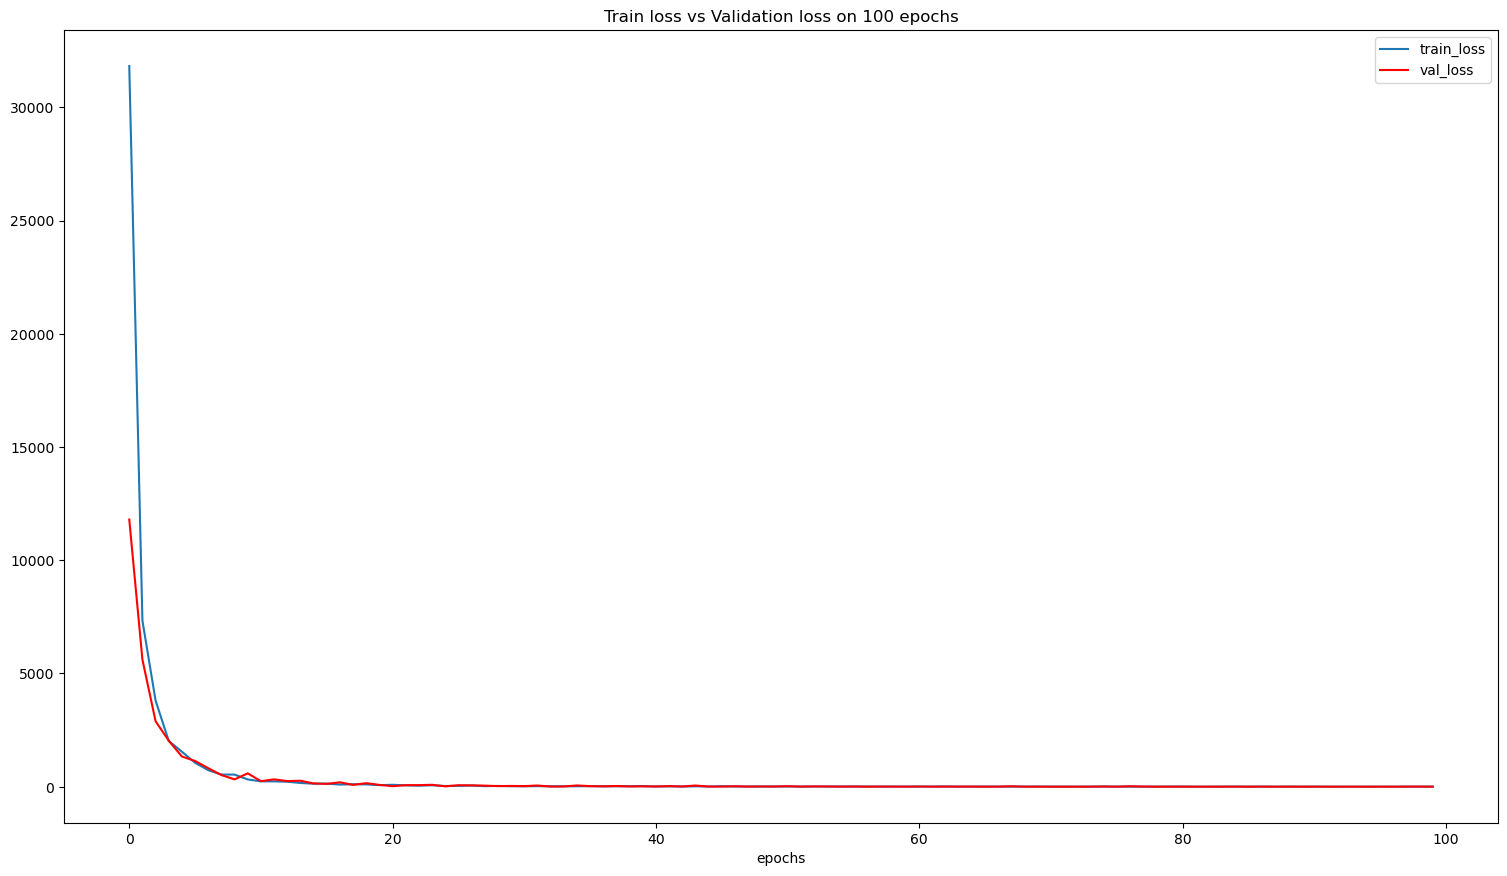

In [219]:
from matplotlib import pyplot as plt
 
def plot_loss(train_loss, val_loss):
    '''
    Visualize training loss vs. validation loss.
    Parameters
    ----------
    train_loss: training loss
    val_loss: validation loss
    Returns: None
    -------
    '''
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    loss_csv = pd.DataFrame({"epochs": range(len(train_loss)), "train_loss": train_loss,
                             "val_loss": val_loss})
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    loss_csv.plot(kind='line',x='epochs',y='train_loss',ax=ax )
    loss_csv.plot(kind='line',x='epochs',y='val_loss', color='red', ax=ax)
    plt.title(f'Train loss vs Validation loss on {len(train_loss)} epochs')
    plt.show()
    # plt.savefig("../outputs/train_vs_val_loss.png")

# Examine results
plot_loss(loss_train, loss_validation)

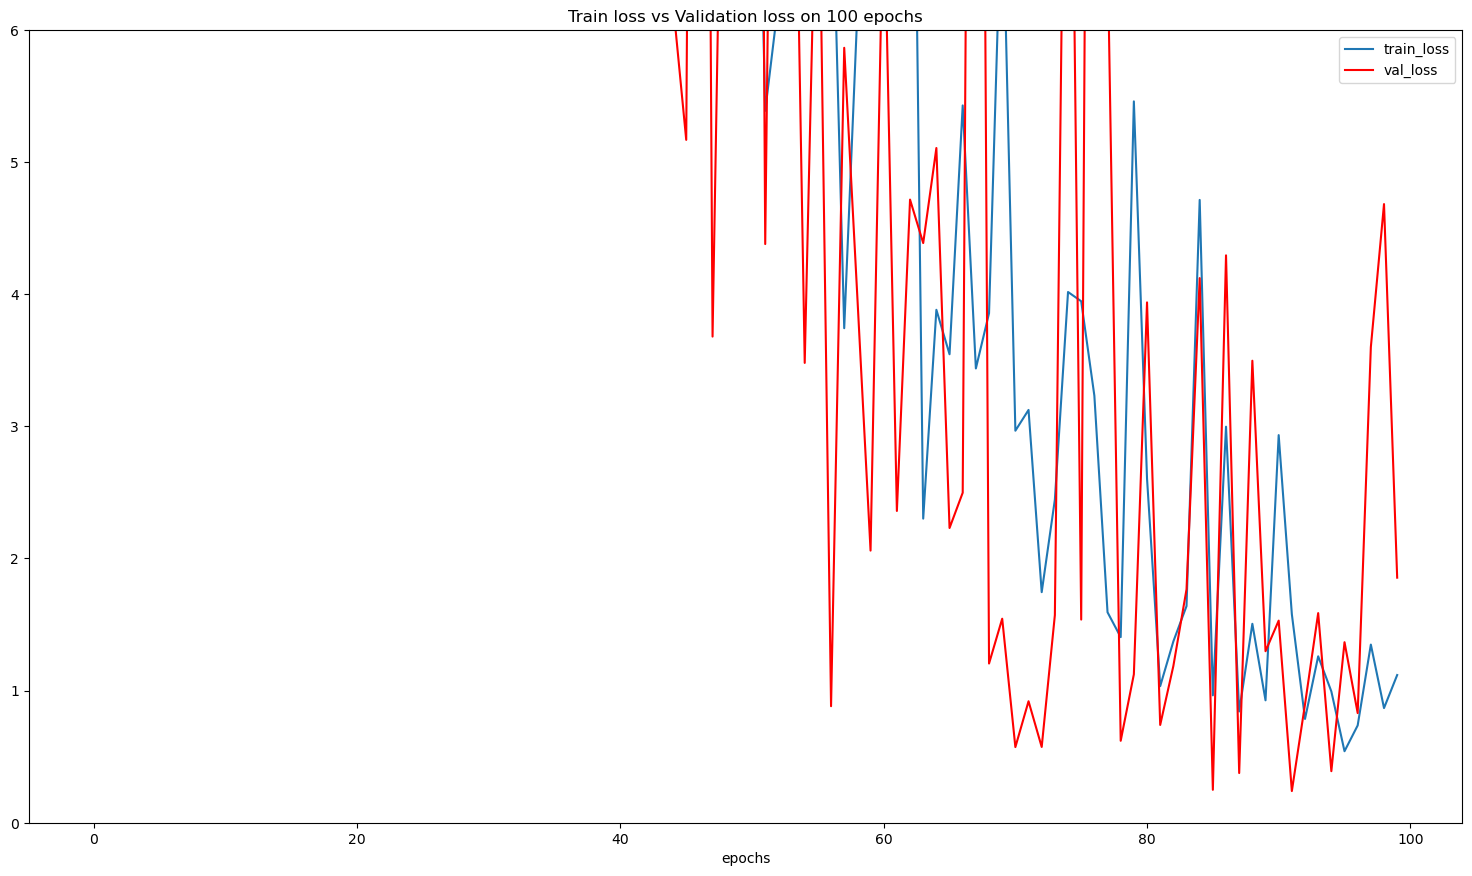

In [220]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)

loss_csv = pd.DataFrame({"epochs": range(len(loss_train)), "train_loss": loss_train,
                            "val_loss": loss_validation})
# loss_csv.to_csv("../outputs/loss.csv")
# gca stands for 'get current axis'
ax = plt.gca()
loss_csv.plot(kind='line',x='epochs',y='train_loss',ax=ax )
loss_csv.plot(kind='line',x='epochs',y='val_loss', color='red', ax=ax)
plt.title(f'Train loss vs Validation loss on {len(loss_train)} epochs')
#plt.xlim([1,100])
plt.ylim([0, 6])
plt.show()

In [221]:
loss_train

[31824.891319444443,
 7327.782528211806,
 3802.8937630208334,
 2016.7294835069445,
 1543.6233018663195,
 1055.004105360243,
 729.9443568250869,
 536.4726402452256,
 533.7546332465278,
 319.7860411919488,
 237.03157657199435,
 235.50502536349828,
 219.00737057156033,
 165.0514394124349,
 130.9181480746799,
 137.00400273217096,
 93.43590585072835,
 107.05031846788195,
 101.42551172044543,
 68.30403361002604,
 83.43091852823893,
 61.417128529018825,
 44.422663175264994,
 63.321094012790255,
 30.021988182067872,
 35.63308489905463,
 52.09868830786811,
 23.592809992896186,
 33.32176371680366,
 19.905269469155204,
 19.280226548512776,
 23.445398716396756,
 18.447993693881564,
 17.955086471769544,
 18.98708102332221,
 22.635706841945648,
 17.023178532388474,
 17.552226977348326,
 21.239043173789977,
 23.284806832207575,
 8.589805829524995,
 16.70625272485945,
 6.600245347552829,
 17.33061229361428,
 10.387284218470256,
 20.409207274648878,
 8.582837255795797,
 9.211169148021273,
 7.3879336992

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

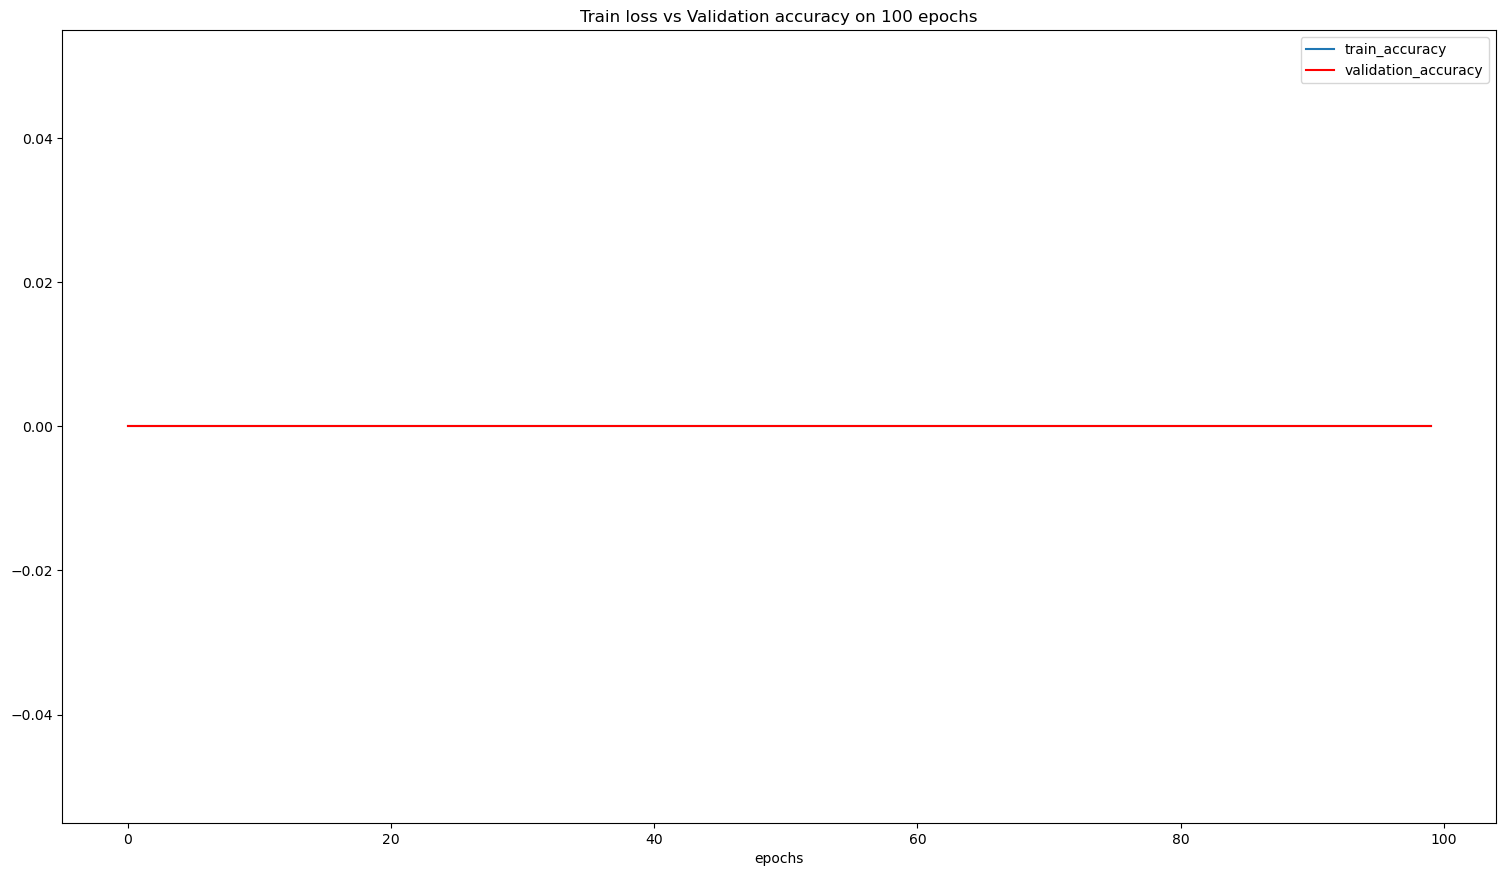

In [222]:
def plot_accuracy(train_accuracy, validation_accuracy):
    """
    TODO: refactor
    """
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    accuracy_csv = pd.DataFrame({
        "epochs": range(len(train_accuracy)), 
        "train_accuracy": train_accuracy,
        "validation_accuracy": validation_accuracy
    })
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    accuracy_csv.plot(kind='line',x='epochs',y='train_accuracy', ax=ax)
    accuracy_csv.plot(kind='line',x='epochs',y='validation_accuracy', color='red', ax=ax)
    plt.title(f'Train loss vs Validation accuracy on {len(train_accuracy)} epochs')
    plt.show()

print(accuracy_train, accuracy_validation)
plot_accuracy(accuracy_train, accuracy_validation)

In [223]:
#df_X_ss = high_scaler.inverse_transform(X_test) # old transformers
#df_y_mm = high_scaler.inverse_transform(y_test) # old transformers

# split the sequence

# converting to tensors
#df_X_ss = Variable(torch.Tensor(df_X_ss))
#df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
#df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))
true, preds = [], []
# test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors), shuffle=False, batch_size=32)
for idx, X_batch in enumerate(test_dl):
    #print(y_batch)
    #break
    X_batch = X_batch.to(device)
    train_predict = mlp(X_batch) #X_test_tensors) # forward pass
    # torch.reshape(train_predict, (32, 1))
    data_predict = train_predict.cpu().data.numpy() # numpy conversion
    # dataY_plot = y_batch.data.numpy() # y_test_tensors.data.numpy()
    # print(data_predict[0].shape)
    # reverse transformation
    data_predict = scaler.inverse_transform(data_predict) 
    # dataY_plot = event_scaler.inverse_transform(dataY_plot)
    # true, preds = [], []
    #for i in range(len(dataY_plot)):
    #    true.append(dataY_plot[i][0])
    for i in range(len(data_predict)):
        # print(data_predict[i][0])
        preds.append(data_predict[i][0])

preds

[0.8269978,
 0.7477848,
 0.72056925,
 0.7477848,
 1.1043597,
 -26.239843,
 0.8747456,
 0.72871864,
 0.7161282,
 0.7408422,
 0.7052928,
 0.703994,
 0.9144596,
 0.73813206,
 2.4271955,
 0.7348138,
 0.91842896,
 0.69877106,
 0.7477848,
 0.7477848,
 1.301475,
 0.73257685,
 0.8532014,
 1.109939,
 0.7477848,
 0.74206483,
 0.7285396,
 0.7535751,
 0.7477848,
 0.7403579,
 0.731135,
 0.73277867,
 0.7093276,
 0.72055346,
 0.86730826,
 0.7301734,
 0.7060326,
 1.244546,
 1.0254002,
 1.0279943,
 0.7477848,
 0.6660275,
 0.7477848,
 0.78396267,
 0.7442285,
 0.7263844,
 0.85069716,
 0.7477848,
 0.7271892,
 0.6846048,
 1.8871942,
 0.7271014,
 1.2685552,
 0.74308264,
 0.7477848,
 0.7477848,
 2.3296118,
 0.56430334,
 1.1824477,
 0.7477848,
 0.86120385,
 3.436675,
 0.7656754,
 0.74493563,
 1.6380663,
 0.7477848,
 0.7477848,
 0.7477848,
 0.7146036,
 0.71841097,
 0.6995818,
 0.7453793,
 0.7466843,
 1.3026084,
 0.7477848,
 0.98715055,
 1.8749075,
 0.7435641,
 0.7065798,
 0.7477848,
 0.96611077,
 0.7477848,
 -

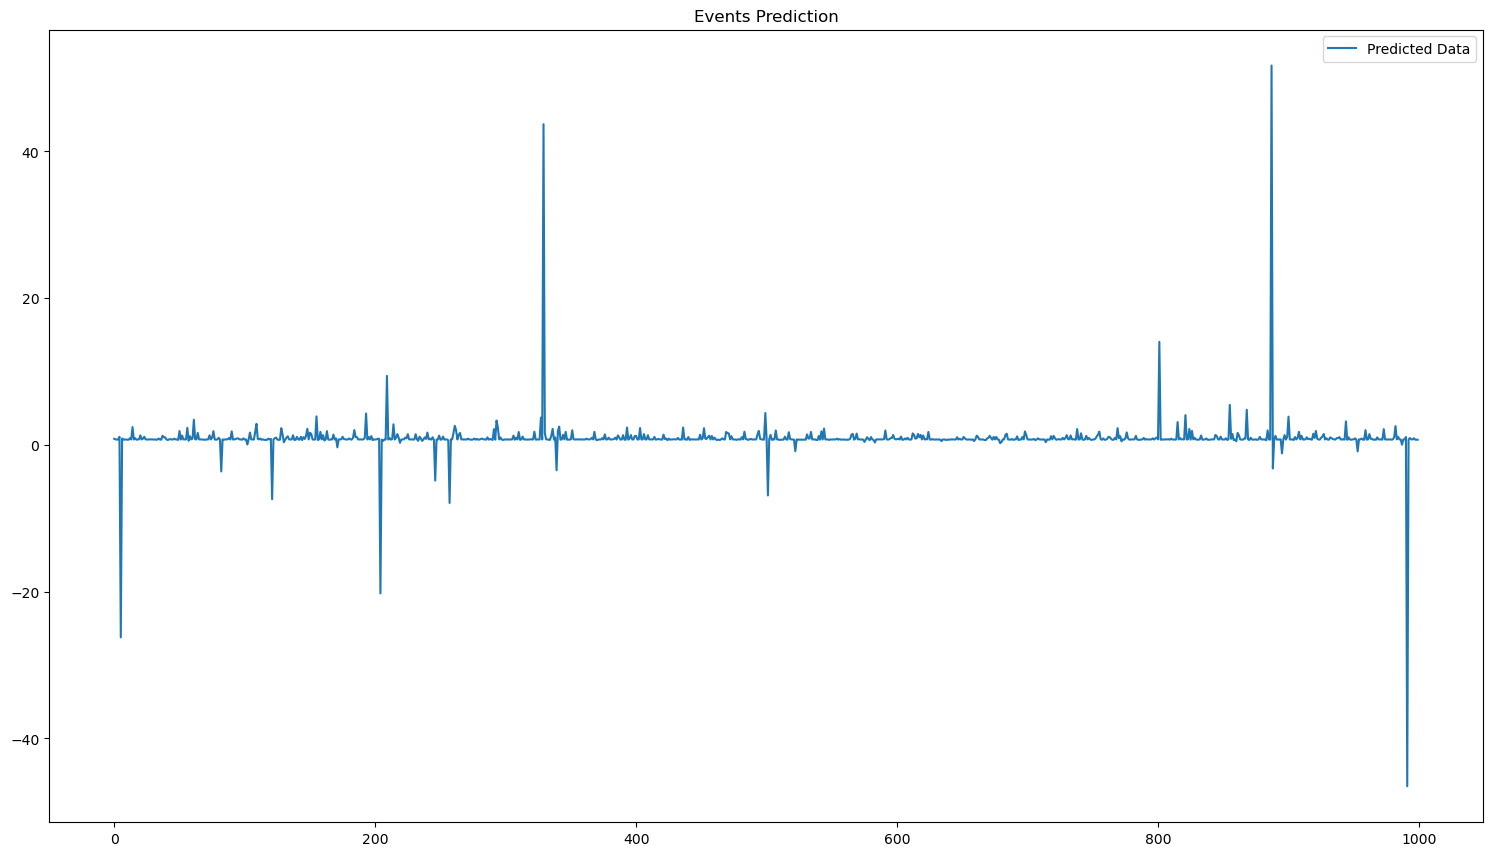

In [224]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)
#plt.axvline(x=0.95, c='r', linestyle='--') # size of the training set

#plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Events Prediction')
#plt.xlim([500, 1000])
#plt.ylim([0, 7])
# my_yticks = ['', ]
#plt.yticks(true, true_new)
#plt.yticks(preds_round, preds_new)
plt.legend()
#plt.savefig("../outputs/1_bitcoin_high_prediction_pytorch.png", transparent=False, dpi=300)
plt.show() 